In [41]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.ops import voronoi_diagram
from shapely.geometry import MultiPoint, Polygon, Point
rng = np.random.default_rng()

import matplotlib.pyplot as plt
import matplotlib

In [2]:
def split_in_voronoi(polygon, sigma1, sigma2, corr, pts = 4):
    
    test = False
    while not(test):   
        x = rng.uniform(polygon.bounds.minx[0],polygon.bounds.maxx[0], pts * 3)
        y = rng.uniform(polygon.bounds.miny[0],polygon.bounds.maxy[0], pts * 3)
        points  = gpd.GeoSeries([Point(xy) for xy in zip(x,y)])
        points = points[points.intersects(polygon.geometry[0])]
        if points.shape[0] >= pts:
            test=True
            points = points[:pts].unary_union    
            
    data = np.exp(rng.multivariate_normal(np.array([0,0]),  np.array([[sigma1**2,corr*sigma1*sigma2], [corr*sigma1*sigma2, sigma2**2]]), 4))
    data = pd.DataFrame(data, columns=['P', 'Q'])
    data.P = polygon.P[0] * data.P
    data.Q = polygon.Q[0] * data.Q
    data['id'] = np.char.add(np.repeat(polygon.id[0]+'_',pts), np.arange(0,pts).astype(str))
    
    
    new_polygons = gpd.GeoDataFrame(data, geometry=gpd.GeoSeries(voronoi_diagram(points, envelope=polygon.unary_union)).explode(index_parts=True).intersection(polygon.unary_union).reset_index( drop=True))#.reset_index(drop=True)
    return(new_polygons)

In [3]:
def recurence(n, polygons,listespolygons, sigma1, sigma2, corr):
    listespolygons[n-1].append(polygons)
    if n > 1:
        for i in range(polygons.shape[0]):            
            recurence(n-1,split_in_voronoi(polygons[i:(i+1)].reset_index([0], drop=True),sigma1, sigma2, corr),
                      listespolygons,
                      sigma1, 
                      sigma2, 
                      corr)

In [4]:
def voronoi_multifractal_voronoi(sigma1=.3, sigma2=.3, corr=-0.8, n=5):
    data = np.exp(rng.multivariate_normal(np.array([0,0]),  np.array([[sigma1**2,corr*sigma1*sigma2], [corr*sigma1*sigma2, sigma2**2]]), 1))
    data = pd.DataFrame(data, columns=['P', 'Q'])
    data['id'] = '0'
    polygon = gpd.GeoDataFrame(data,geometry=gpd.GeoSeries(Polygon([(0,0), (0,1), (1,1), (1,0)])))
    
    listespolygons = dict()
    for i in range(n):
        listespolygons[i] = []

    recurence(n, polygon, listespolygons, sigma1, sigma2, corr)

    voronoi = dict()
    for i in range(n):
        voronoi[n-i-1] = pd.concat(listespolygons[i])
    return(voronoi)

In [37]:
n = 6
voronoi = voronoi_multifractal_voronoi(sigma1=.3, sigma2=.7, corr=0.2,n=n)
voronoi[n-1]['poverty_rate'] = 100 * voronoi[n-1]['P'] /(voronoi[n-1]['P'] + voronoi[n-1]['Q']) 
voronoi[n-1]['P_density'] = 100 * voronoi[n-1]['P'] / voronoi[n-1].area 

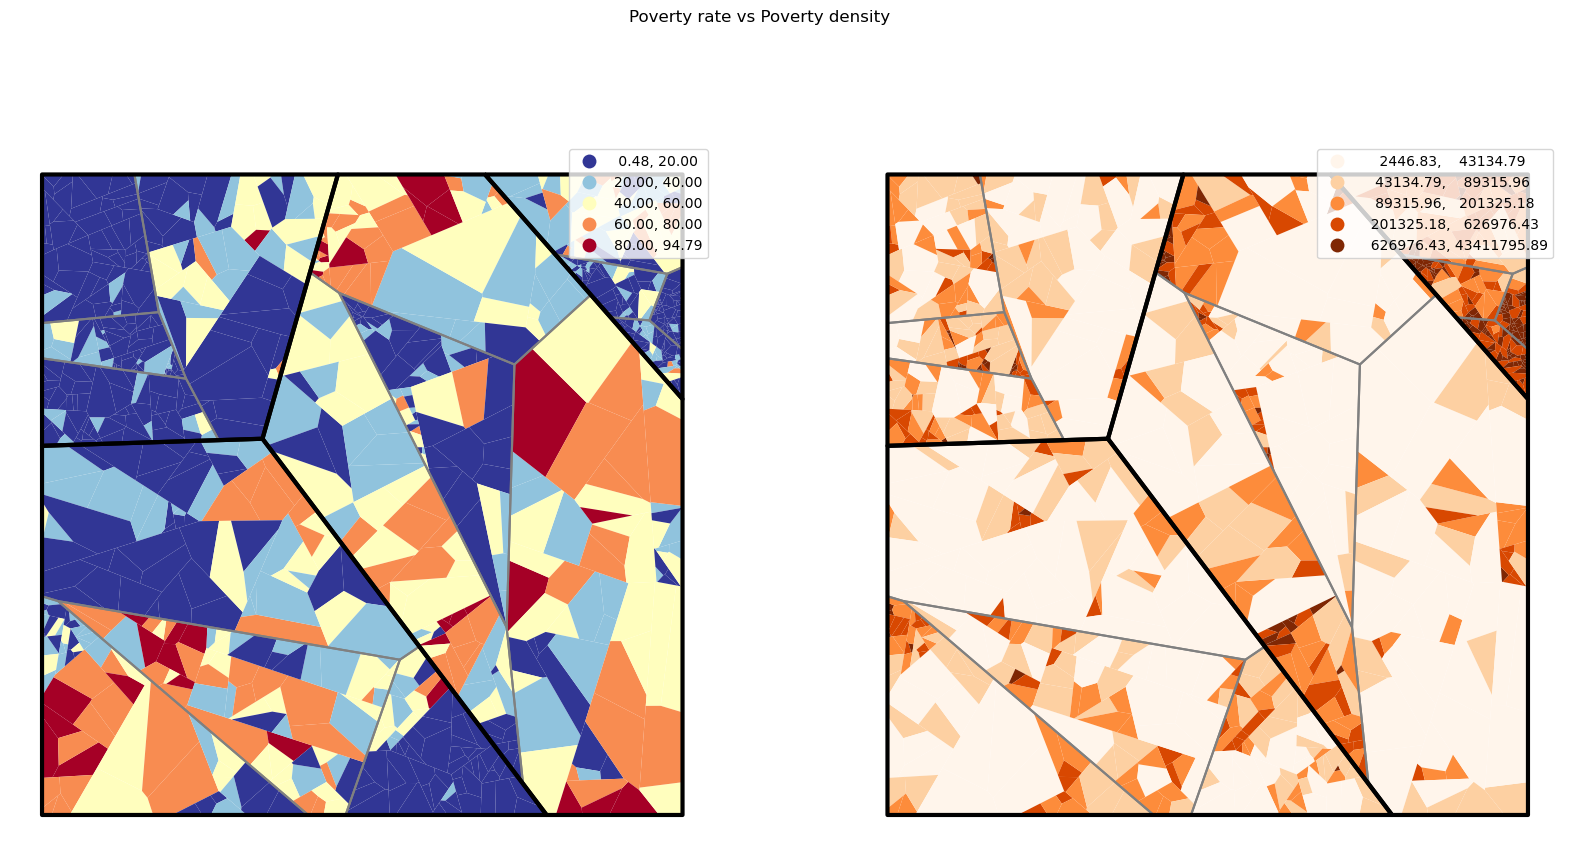

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Poverty rate vs Poverty density')
voronoi[n-1].plot('poverty_rate', figsize=(10,10), cmap='RdYlBu_r', scheme='userdefined', 
                classification_kwds={'bins':[20, 40, 60, 80]},legend=True, ax=ax1)
voronoi[2].boundary.plot(ax=ax1, color='grey', linewidth=1.5)
voronoi[1].boundary.plot(ax=ax1, color='black', linewidth=3)
ax1.set_axis_off()
voronoi[n-1].plot('P_density', figsize=(10,10), cmap='Oranges', scheme='quantiles', legend=True,ax=ax2)
ax2.set_axis_off()
voronoi[2].boundary.plot(ax=ax2, color='grey', linewidth=1.5)
voronoi[1].boundary.plot(ax=ax2, color='black', linewidth=3);

## rasterize

In [31]:
from geocube.api.core import make_geocube

In [58]:
P_grid= make_geocube(vector_data=voronoi[n-1], measurements=["P"], resolution=(1/256, 1/256))
Q_grid= make_geocube(vector_data=voronoi[n-1], measurements=["Q"], resolution=(1/256, 1/256))    
poverty_rate_grid= make_geocube(vector_data=voronoi[n-1], measurements=["poverty_rate"], resolution=(1/256, 1/256))
fractal = np.stack((P_grid.P,Q_grid.Q), axis=-1)

/tmp/ipykernel_5705/4250487462.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('RdYlBu_r', 5)


(-0.5, 255.5, 255.5, -0.5)

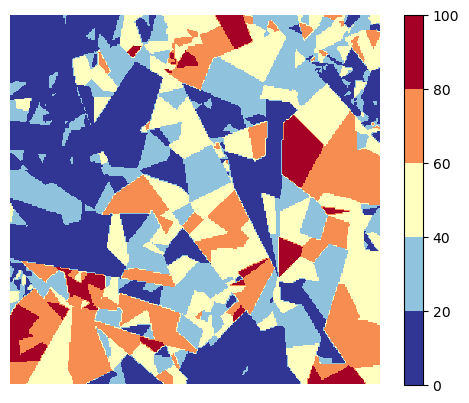

In [53]:
cmap = matplotlib.cm.get_cmap('RdYlBu_r', 5)
plt.imshow(np.flip(poverty_rate_grid.poverty_rate,0), cmap=cmap,vmin=0,vmax=100)
plt.colorbar()
plt.axis("off")

In [61]:
np.save('voronoi_fractal', fractal)